LangGraph for Beginners, Part 4: StateGraph

https://readmedium.com/building-agentic-applications-with-langgraph-part-3-hierarchical-agent-teams-3406fd02ceda

In [1]:
!pip install autogen-agentchat~=0.2 autogen psutil --quiet
# !pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental yfinance
!pip install -q langchain-openai langchain-anthropic termcolor langchain_community duckduckgo_search wikipedia openapi-python-client langgraph langchain_experimental openai --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import autogen
from typing import Literal

from pydantic import BaseModel, Field
from typing_extensions import Annotated

import autogen
from autogen.cache import Cache
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langgraph.graph import END, StateGraph, START

INFERENCE_SERVER_URL = "http://localhost:8000"
MODEL_NAME = "ibm-granite/granite-3.0-8b-instruct"
API_KEY= "alanliuxiang"


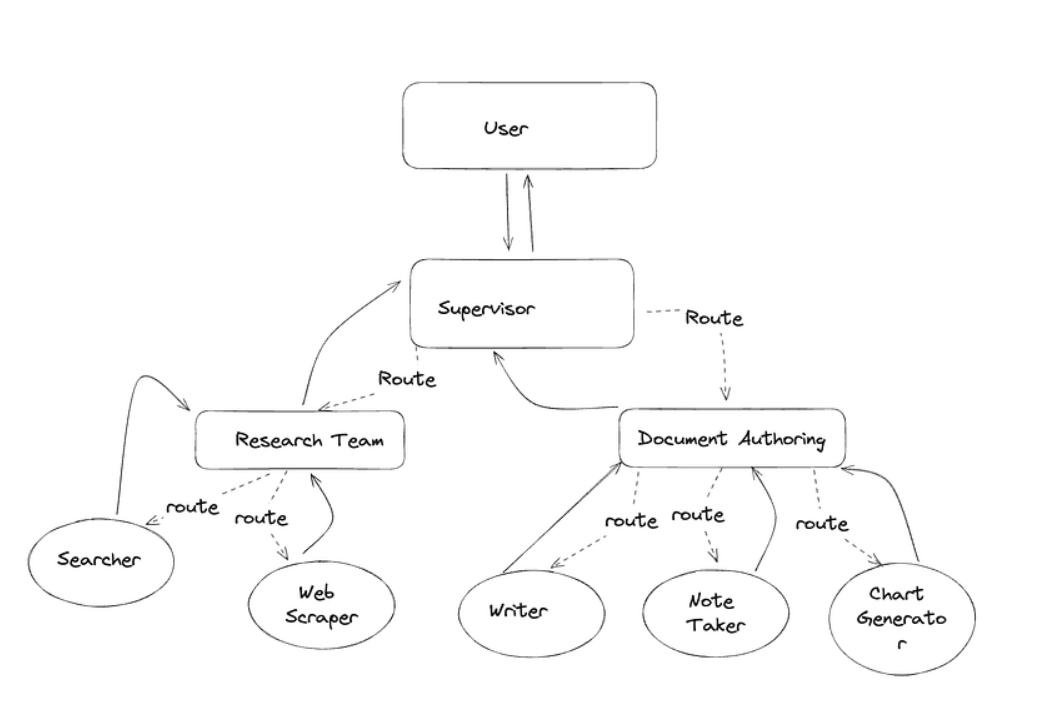

In [3]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

import getpass
import os

os.environ["TAVILY_API_KEY"] = "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"


llm = ChatOpenAI(
    openai_api_key=API_KEY,
    openai_api_base= f"{INFERENCE_SERVER_URL}/v1",
    model_name=MODEL_NAME,
    top_p=0.92,
    temperature=0.01,
    max_tokens=512,
    presence_penalty=1.03,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)


Research Team Tools

In [4]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


Document Writing Team Tools

In [5]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

Building the Hierarchy
Our system uses three levels of hierarchy:
Top-Level Supervisor Coordinates between research and writing teams Makes high-level decisions about workflow

2. Research Team
Supervisor managing specialized agents
Search agent for finding information Web scraper agent for detailed content extraction

3. Document Writing Team
Supervisor coordinating document creation Note-taking agent for creating outlines
Writing agent for content generationChart generation agent for visualizations

In [6]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, trim_messages


# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: MessagesState) -> MessagesState:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        next_ = response["next"]
        if next_ == "FINISH":
            next_ = END

        return {"next": next_}

    return supervisor_node

In [7]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# llm = ChatOpenAI(model="gpt-4o-mini")

search_agent = create_react_agent(llm, tools=[tavily_tool])


def search_node(state: AgentState) -> AgentState:
    result = search_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="search")
        ]
    }


web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: AgentState) -> AgentState:
    result = web_scraper_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="web_scraper")
        ]
    }


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

research_builder = StateGraph(MessagesState)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

# Define the control flow
research_builder.add_edge(START, "supervisor")
# We want our workers to ALWAYS "report back" to the supervisor when done
research_builder.add_edge("search", "supervisor")
research_builder.add_edge("web_scraper", "supervisor")
# Add the edges where routing applies
research_builder.add_conditional_edges("supervisor", lambda state: state["next"])

research_graph = research_builder.compile()

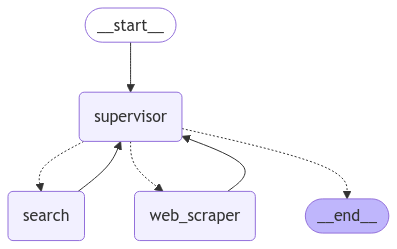

In [8]:
# Visualize your graph
from IPython.display import Image, display
png = research_graph.get_graph().draw_mermaid_png()

display(Image(png))

Now, we follow the same process and build the document writer graph, completing the sub-agents of our research team

In [9]:
# llm = ChatOpenAI(model="gpt-4o-mini")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    state_modifier=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: AgentState) -> AgentState:
    result = doc_writer_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="doc_writer")
        ]
    }


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    state_modifier=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: AgentState) -> AgentState:
    result = note_taking_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="note_taker")
        ]
    }


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: AgentState) -> AgentState:
    result = chart_generating_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="chart_generator")
        ]
    }


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

# Create the graph here
paper_writing_builder = StateGraph(AgentState)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

# Define the control flow
paper_writing_builder.add_edge(START, "supervisor")
# We want our workers to ALWAYS "report back" to the supervisor when done
paper_writing_builder.add_edge("doc_writer", "supervisor")
paper_writing_builder.add_edge("note_taker", "supervisor")
paper_writing_builder.add_edge("chart_generator", "supervisor")
# Add the edges where routing applies
paper_writing_builder.add_conditional_edges("supervisor", lambda state: state["next"])

paper_writing_graph = paper_writing_builder.compile()

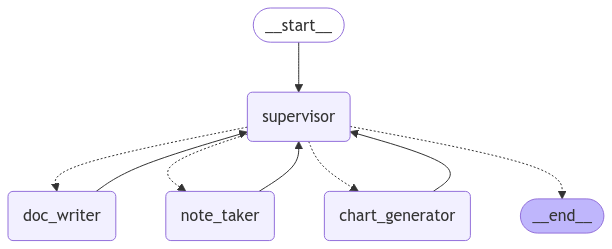

In [10]:
# Visualize your graph
from IPython.display import Image, display
png = paper_writing_graph.get_graph().draw_mermaid_png()

display(Image(png))

Since we have all the pieces in place, we now setup the top level supervisor and complete our hierarchical super graph

In [11]:
from langchain_core.messages import BaseMessage

# llm = ChatOpenAI(model="gpt-4o-mini")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])


def call_research_team(state: AgentState) -> AgentState:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="research_team")
        ]
    }


def call_paper_writing_team(state: AgentState) -> AgentState:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="writing_team")
        ]
    }


# Define the graph.
super_builder = StateGraph(AgentState)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

# Define the control flow
super_builder.add_edge(START, "supervisor")
# We want our teams to ALWAYS "report back" to the top-level supervisor when done
super_builder.add_edge("research_team", "supervisor")
super_builder.add_edge("writing_team", "supervisor")
# Add the edges where routing applies
super_builder.add_conditional_edges("supervisor", lambda state: state["next"])
super_graph = super_builder.compile()

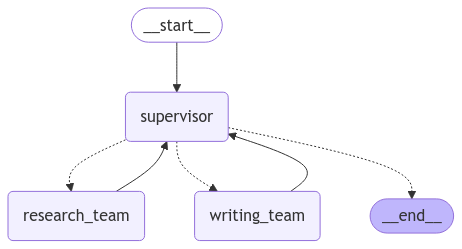

In [12]:
# Visualize your graph
from IPython.display import Image, display
png = super_graph.get_graph().draw_mermaid_png()

display(Image(png))

Let’s test

In [13]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research Model context protocols and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{
"next": "research_team"
}{'supervisor': {'next': 'research_team'}}
---
{
"next": "search"
}Title: Research Model Context Protocols

Context protocols in research models refer to the set of guidelines and procedures that define the context in which a research study is conducted. These protocols ensure that the research is conducted in a manner that is ethical, reliable, and valid.

There are several types of context protocols, including:

1. Ethical Protocols: These protocols ensure that the research is conducted in an ethical manner, respecting the rights and dignity of all participants. They may include guidelines for obtaining informed consent, protecting participant confidentiality, and avoiding harm to participants.

2. Methodological Protocols: These protocols define the methods used to collect and analyze data. They may include guidelines for sampling, data collection, data analysis, and data interpretation.

3. Theoretical Protocols: These protocols define the theoretical fram

BadRequestError: Error code: 400 - {'object': 'error', 'message': "This model's maximum context length is 4096 tokens. However, you requested 4146 tokens (3634 in the messages, 512 in the completion). Please reduce the length of the messages or completion.", 'type': 'BadRequestError', 'param': None, 'code': 400}